In [1]:
# load required packages
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import glob
import tweepy
import json
import re
import matplotlib as plt
import seaborn as sns
%matplotlib inline
import requests

## 收集

####  include: 　　
'image-predictions.tsv': breed prediction　　

'tweet_json.txt': tweet data include (retweet_count,favorite_count,ID)　　

'twitter-archive-enhanced.csv':cleaned twitter archive


##### 第一个文件是预测小狗品种，需要使用request 库来获取

In [2]:
 url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'

In [92]:
try:
    r = requests.get(url)
    r.raise_for_status()
    r.encodinig = r.apparent_encoding
    print(r.text[:100])
except:
    print('获取失败')

tweet_id	jpg_url	img_num	p1	p1_conf	p1_dog	p2	p2_conf	p2_dog	p3	p3_conf	p3_dog
666020888022790149	ht


In [93]:
#保存文件
with open('image-predictions.tsv',mode='wb') as f:
    f.write(r.content)

In [94]:
# 读取文件
predictions = pd.read_csv('image-predictions.tsv',delimiter = '\t')

In [95]:
predictions.head(n=1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


##### Second file

In [101]:
#keys = id, retweet count, and favorite count
df = pd.read_json('tweet_json.txt',lines=True)

In [102]:
df.head(1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39492,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8842,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [103]:
#列出所有列名
df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

##### 这个表格有很多问题，内容跟另一个表格也有重复。为了简化和项目需要，这里只提取三个列

In [104]:
df = df[['id','retweet_count','favorite_count']]

##### Third file

In [105]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [106]:
twitter_archive.head(n=1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### 在清洗前为三个文件建立副本

In [107]:
pre_clean = predictions.copy()

In [108]:
df_clean = df.copy()

In [109]:
archive_clean = twitter_archive.copy()

# 文件1：image-predictions.tsv

### 评估

In [110]:
#第一个文件
#先大致了解下数据信息。条数及数值类型
pre_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [111]:
#预览前五条内容
pre_clean.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [112]:
#预览后五条内容
pre_clean.tail(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [113]:
#查看是否有重复id
tweetid = pre_clean['tweet_id'].duplicated()

In [114]:
pre_clean.jpg_url.duplicated().value_counts()

False    2009
True       66
Name: jpg_url, dtype: int64

In [115]:
tweetid.value_counts()

False    2075
Name: tweet_id, dtype: int64

In [116]:
pre_clean.tweet_id.isnull().value_counts()

False    2075
Name: tweet_id, dtype: int64

In [117]:
pre_clean.p1.isnull().value_counts()

False    2075
Name: p1, dtype: int64

In [118]:
pre_clean.p1_dog.isnull().value_counts()

False    2075
Name: p1_dog, dtype: int64

### 质量
- tweet_id 类型错误，应该是字符型。这里是整数类型。
- jpg_url 有重复值，考虑到同一网页可能有多张图片。这里考虑不做进一步处理

### 代码

In [119]:
pre_clean.tweet_id = pre_clean.tweet_id.astype(str)

### 测试

In [120]:
pre_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


# 文件2：tweet_json.txt

### 评估

In [121]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
id                2352 non-null int64
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [122]:
check_null = df_clean.isnull()

In [123]:
check_null.any()

id                False
retweet_count     False
favorite_count    False
dtype: bool

In [124]:
df_clean.head(5)

,id,retweet_count,favorite_count
0,892420643555336193,8842,39492
1,892177421306343426,6480,33786
2,891815181378084864,4301,25445
3,891689557279858688,8925,42863
4,891327558926688256,9721,41016


In [125]:
#检查是否有重复项
df_clean['id'].is_unique

True

In [126]:
#是否需要检查Id的位数？
df_clean['id'].apply(lambda x:len(str(x))).value_counts()

18    2352
Name: id, dtype: int64

In [127]:
df_clean.tail(5)

,id,retweet_count,favorite_count
2347,666049248165822465,41,111
2348,666044226329800704,147,309
2349,666033412701032449,47,128
2350,666029285002620928,48,132
2351,666020888022790149,530,2528


### 质量
- id应该是字符型，这里是整数类型

### 代码

In [128]:
df_clean.id=df_clean.id.astype(str)

### 测试

In [129]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
id                2352 non-null object
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


## 文件3：twitter-archive-enhanced.csv

### 评估

In [130]:
#第三个文件
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [131]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [132]:
archive_clean.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [133]:
archive_clean.isnull().any()

tweet_id                      False
in_reply_to_status_id          True
in_reply_to_user_id            True
timestamp                     False
source                        False
text                          False
retweeted_status_id            True
retweeted_status_user_id       True
retweeted_status_timestamp     True
expanded_urls                  True
rating_numerator              False
rating_denominator            False
name                          False
doggo                         False
floofer                       False
pupper                        False
puppo                         False
dtype: bool

In [134]:
#检查有多少属于转发数据的
archive_clean['retweeted_status_id'][archive_clean['retweeted_status_id'].notnull()].count()

181

In [135]:
archive_clean['retweeted_status_user_id'][archive_clean['retweeted_status_user_id'].notnull()].count()

181

In [136]:
archive_clean['source'][1]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [137]:
archive_clean['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [138]:
#查看是否有重复值
archive_clean['tweet_id'].is_unique

True

In [139]:
#查看是否有完全没有评级的
archive_clean[(archive_clean.floofer=='None')&(archive_clean.pupper=='None')&(archive_clean.puppo=='None')&(archive_clean.doggo=='None')].count()

tweet_id                      1976
in_reply_to_status_id           70
in_reply_to_user_id             70
timestamp                     1976
source                        1976
text                          1976
retweeted_status_id            145
retweeted_status_user_id       145
retweeted_status_timestamp     145
expanded_urls                 1923
rating_numerator              1976
rating_denominator            1976
name                          1976
doggo                         1976
floofer                       1976
pupper                        1976
puppo                         1976
dtype: int64

In [140]:
#查看分子分母信息
archive_clean['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [141]:
archive_clean['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [142]:
#查看分子大于20的几条信息
archive_clean[['text','rating_numerator','rating_denominator']][archive_clean.rating_numerator > 20]

,text,rating_numerator,rating_denominator
188,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
189,@s8n You tried very hard to portray this good ...,666,10
290,@markhoppus 182/10,182,10
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
340,"RT @dog_rates: This is Logan, the Chow who liv...",75,10
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
902,Why does this never happen at my front door......,165,150


In [143]:
#查看分子大于10的几条信息
archive_clean[['text','rating_numerator','rating_denominator']][archive_clean.rating_denominator > 10]

,text,rating_numerator,rating_denominator
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
784,"RT @dog_rates: After so many requests, this is...",9,11
902,Why does this never happen at my front door......,165,150
1068,"After so many requests, this is Bretagne. She ...",9,11
1120,Say hello to this unbelievably well behaved sq...,204,170
1165,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,This is Bluebert. He just saw that both #Final...,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99...,99,90
1254,Here's a brigade of puppers. All look very pre...,80,80


In [144]:
#查看分子等于0的信息
archive_clean[['text','rating_numerator','rating_denominator']][archive_clean.rating_denominator == 0]

,text,rating_numerator,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0


In [145]:
#查看名字信息
archive_clean['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
Oliver       11
Penny        10
Lola         10
Tucker       10
Bo            9
Winston       9
the           8
Sadie         8
an            7
Buddy         7
Daisy         7
Toby          7
Bailey        7
Jax           6
Scout         6
Dave          6
Stanley       6
Milo          6
Oscar         6
Bella         6
Rusty         6
Leo           6
Koda          6
Jack          6
Louis         5
           ... 
Rizzo         1
Joshwa        1
Traviss       1
Derby         1
Dobby         1
Bones         1
Kramer        1
Adele         1
Jordy         1
Jed           1
Mingus        1
Crumpet       1
Brutus        1
Glenn         1
Banjo         1
Zuzu          1
Ginger        1
Cheryl        1
Brandy        1
Theo          1
Brady         1
light         1
Andru         1
Rolf          1
Walker        1
Pepper        1
Bobble        1
Chuq          1
Jeb           1
Jennifur      1
Name: name, Length: 957,

In [146]:
#进一步检查名字
archive_clean.name[archive_clean.name.str.islower()].value_counts()

a               55
the              8
an               7
very             5
quite            4
one              4
just             4
actually         2
getting          2
mad              2
not              2
all              1
infuriating      1
light            1
my               1
old              1
life             1
incredibly       1
his              1
unacceptable     1
this             1
space            1
officially       1
such             1
by               1
Name: name, dtype: int64

In [147]:
archive_clean['in_reply_to_status_id'].isnull().value_counts()

True     2278
False      78
Name: in_reply_to_status_id, dtype: int64

In [148]:
#pd.set_option('display.max_colwidth',-1)

In [149]:
archive_clean.expanded_urls.isnull().value_counts()

False    2297
True       59
Name: expanded_urls, dtype: int64

##### 质量：

- tweet_id 类型应该是字符，这里是整数类型
- in_replay_to_status_id和in_replay_to_user_id类型错误，应该是字符，这里却是浮点
- timestamp 类型应该是时间类型，这里是object
- source有无意义html标签信息
- 错误类型： retweeted_status_id, retweeted_status_user_id 应为字符，这里是浮点
- 以下列含有大量nul值：{in_reply_to_status_id，in_reply_to_user_id retweeted_status_id，retweeted_status_user_id， retweeted_status_timestamp	retweeted_status_timestamp}　　　
- 小狗的名字:name 有缺失值 （无法处理）
- name里很多非名字的单词，比如'a','the','an','very'等 （暂时无法处理）
- rating_denominator中有值为0的(分母不能为0)
- 根据项目动机只考虑原创不考虑转发，这里有部分属于转发的信息需要去掉
- 在rating_denominator里有23条是其它数字,大致分析如下： 其中有两条看起来应该是日期，一个是docmisterio account started on 11/15/15，一个是 9/11. 除了一两个无效评分，有一部分是代表图片中有多只狗。如：Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody。（这里不暂不处理）
- rating_numerator 里有一些非常大的数字，比如三位数或者四位数。结合分母来看，除了一两个异常值外，大部分是为多只狗狗评分。可以考虑平均分，但是考虑到狗的数量不一定能准确获取，这里暂不处理。
- expanded_urls字段有少量null，根据档案说明，这是正常的，因此这里考虑不处理。
- 小狗地位有1000多条都是没有评级信息的 （这里暂不处理）





##### 清洁度：
- 小狗信息按评级分了四列，显示不清晰。合并成一列显示。
- 评级：rating_numerator,rating_denominator 同一变量分成两列
- source列是客户端来源，考虑保留客户端分类而移除url信息。

In [150]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### 定义： tweet_id 类型改成字符型，in_replay_to_status_id和in_replay_to_user_id改为字符型。timestamp 类型改为时间类型

#### 代码

In [151]:
#tweet_id类型转换
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

In [152]:
#timestamp类型转换
archive_clean.timestamp=pd.to_datetime(archive_clean.timestamp)

#### 测试

In [153]:
archive_clean.timestamp[2]

Timestamp('2017-07-31 00:18:03')

In [154]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

#### 定义：source有无意义html标签信息,[1source列是客户商量来源，考虑保留客户端分类而移除url信息。

#### 代码

In [155]:
patten = r'<a .*>(.*)</a>'
archive_clean['source'] = archive_clean['source'].str.extract(patten,expand=False)    

#### 测试

In [156]:
archive_clean.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

####  定义：去掉denominator为0的无效评分，将rating_numerator,rating_denominator 将合成一列

In [157]:
archive_clean = archive_clean[archive_clean.rating_denominator != 0]

In [158]:
archive_clean['rating_value'] = archive_clean.rating_numerator.astype(str)+'/'+archive_clean.rating_denominator.astype(str)

In [159]:
archive_clean = archive_clean.drop(['rating_numerator','rating_denominator'],axis=1)

#### 测试

In [160]:
archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,rating_value
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,None,None,None,None,13/10


#### 定义 将狗地位4列合并成一列

#### 代码

In [161]:
#狗评级名称
key = ['doggo','floofer','pupper','puppo']

In [162]:
#pd.set_option('display.max_colwidth',-1)

In [163]:
archive_clean[key] = archive_clean[key].replace('None','')

In [164]:
archive_clean['rating_name'] = archive_clean.doggo+archive_clean.floofer+archive_clean.pupper+archive_clean.puppo

In [165]:
archive_clean = archive_clean.drop(key,axis=1)

#### 测试

In [166]:
archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,rating_value,rating_name
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,13/10,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,Tilly,13/10,


In [167]:
archive_clean.rating_name.value_counts()

                1975
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: rating_name, dtype: int64

## 合并

#### 合并前再看个需要合并的数据信息,可以看出两个文件的行数不同,那么根据合并的方式会产生null值. 因此合并之后还需要评估清洗

In [168]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
id                2352 non-null object
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [169]:
pre_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [170]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                      2355 non-null object
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2355 non-null datetime64[ns]
source                        2355 non-null object
text                          2355 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
name                          2355 non-null object
rating_value                  2355 non-null object
rating_name                   2355 non-null object
dtypes: datetime64[ns](1), float64(4), object(8)
memory usage: 257.6+ KB


In [64]:
#tweets_df_clean.rename(columns={'id':'tweet_id'},inplace=True)  #如果不加inplace=True重新赋值

In [218]:
#result = pd.merge(tweets_df_clean,archive_clean,on='tweet_id')  #使用left_on 或者 right_on 可以不需要更改原数据表的列。

### 合并archive文件和预测文件，过滤掉没有图片的数据

In [171]:
result = pd.merge(archive_clean,pre_clean,on = 'tweet_id',how = 'inner')

In [172]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 24 columns):
tweet_id                      2075 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null datetime64[ns]
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2075 non-null object
name                          2075 non-null object
rating_value                  2075 non-null object
rating_name                   2075 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null int64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
p1_dog                  

### 再合并tweet_json提取的表格

In [173]:
result = pd.merge(result,df_clean,left_on = 'tweet_id',right_on = 'id',how='inner')

### 评估:合并文件

In [174]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 27 columns):
tweet_id                      2073 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null datetime64[ns]
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
name                          2073 non-null object
rating_value                  2073 non-null object
rating_name                   2073 non-null object
jpg_url                       2073 non-null object
img_num                       2073 non-null int64
p1                            2073 non-null object
p1_conf                       2073 non-null float64
p1_dog                  

### 保存一份合并后文件副本

In [175]:
result_clean = result.copy()

#### 定义:合并后有4条信息是tweet_json里没有的,这部分是转发信息,因此可以考虑删掉,因为这个项目里我们只考虑原创数据.另一条是只有tweet_json里才有的信息,推特档案里没有这个id,因此考虑删掉.

In [176]:
#去掉转发信息
k = 'retweeted_status_id'
result_clean = result_clean[result_clean[k].isnull()==True]

#### 测试

In [177]:
result_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 27 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
name                          1994 non-null object
rating_value                  1994 non-null object
rating_name                   1994 non-null object
jpg_url                       1994 non-null object
img_num                       1994 non-null int64
p1                            1994 non-null object
p1_conf                       1994 non-null float64
p1_dog                     

In [178]:
result_clean.retweeted_status_id.isnull().count()

1994

#### 定义：因为项目只考虑原创所以可以去掉转发相关列。in_reply开头两列有大量缺失值，这里同样考虑删除掉。

#### 代码

In [179]:
result_clean = result_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'],axis=1)

#### 测试

In [180]:
result_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 22 columns):
tweet_id          1994 non-null object
timestamp         1994 non-null datetime64[ns]
source            1994 non-null object
text              1994 non-null object
expanded_urls     1994 non-null object
name              1994 non-null object
rating_value      1994 non-null object
rating_name       1994 non-null object
jpg_url           1994 non-null object
img_num           1994 non-null int64
p1                1994 non-null object
p1_conf           1994 non-null float64
p1_dog            1994 non-null bool
p2                1994 non-null object
p2_conf           1994 non-null float64
p2_dog            1994 non-null bool
p3                1994 non-null object
p3_conf           1994 non-null float64
p3_dog            1994 non-null bool
id                1994 non-null object
retweet_count     1994 non-null int64
favorite_count    1994 non-null int64
dtypes: bool(3), datetime64[ns](1

#### 合并过程中,因缺失值而造成retweet_count和favorite_count数据类型的改变,需改回来

In [181]:
result_clean[['retweet_count','favorite_count']] = result_clean[['retweet_count','favorite_count']].astype(int)

#### 测试

In [182]:
result_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 22 columns):
tweet_id          1994 non-null object
timestamp         1994 non-null datetime64[ns]
source            1994 non-null object
text              1994 non-null object
expanded_urls     1994 non-null object
name              1994 non-null object
rating_value      1994 non-null object
rating_name       1994 non-null object
jpg_url           1994 non-null object
img_num           1994 non-null int64
p1                1994 non-null object
p1_conf           1994 non-null float64
p1_dog            1994 non-null bool
p2                1994 non-null object
p2_conf           1994 non-null float64
p2_dog            1994 non-null bool
p3                1994 non-null object
p3_conf           1994 non-null float64
p3_dog            1994 non-null bool
id                1994 non-null object
retweet_count     1994 non-null int32
favorite_count    1994 non-null int32
dtypes: bool(3), datetime64[ns](1

In [183]:
result_clean.head(2)

,tweet_id,timestamp,source,text,expanded_urls,name,rating_value,rating_name,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,id,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,13/10,,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,False,bagel,0.085851,False,banana,0.076110,False,892420643555336193,8842,39492
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,13/10,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,True,Pekinese,0.090647,True,papillon,0.068957,True,892177421306343426,6480,33786


## 保存清理过的文件

In [184]:
result_clean.to_csv('twitter_archive_master.csv',index = False)

In [185]:
pre_clean.to_csv('prediction_master.csv',index = False)

## 可视化&分析

#### 查看下转发量分布,可以看出分布比较偏斜. 这是符合现实状态.

C:\Users\Casper\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\Casper\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


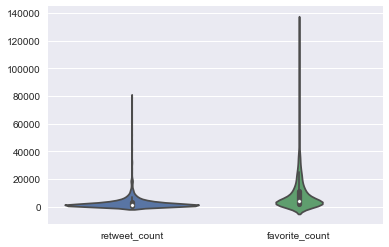

In [186]:
sns.violinplot(data=result_clean[['retweet_count','favorite_count']])

#### 查看下点赞最多的前15个评级. 从这里看出,受欢迎的其实评分是正常的评分,不会出现分子极大的情况.

In [187]:
idx = result_clean['favorite_count'].sort_values(ascending=False)[:15].index

In [188]:
result_clean[['rating_value','favorite_count']].iloc[idx].sort_values('favorite_count',ascending=False)

,rating_value,favorite_count
22,13/10,70007
99,13/10,43546
470,11/10,31655
116,13/10,28978
35,13/10,28429
68,12/10,23188
60,12/10,17061
145,12/10,16883
350,11/10,14863
298,13/10,12887


#### 通过可视化source列,可以直观的看出数据主要来自哪种客户端,这里的主要用户来自苹果端.

C:\Users\Casper\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


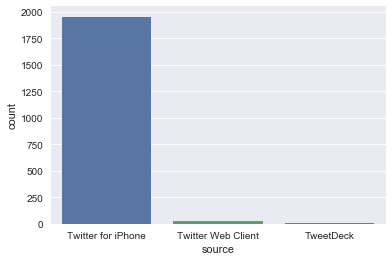

In [189]:
sns.countplot(result_clean.source)

C:\Users\Casper\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


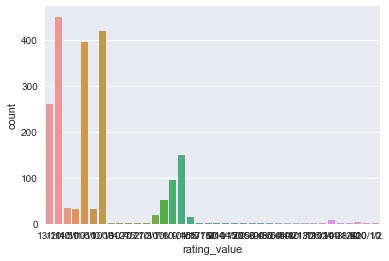

In [190]:
sns.countplot(result_clean.rating_value)